In [1]:
%load_ext autoreload
%autoreload 2

some imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# some imports from my project library
from turboflow.dataloaders import load_turbo2D_simple_numpy
from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp
from turboflow.utils import torch_utils as tch
from turboflow.utils import viz_utils as viz
from turboflow import evaluation as evl


# import torch lib
import torch
from turboflow.dataloaders import Turbo2D_simple
from torch.utils.data import Dataset, DataLoader

In [3]:
device = tch.get_device()

Torch running on: cuda:0


In [4]:
results_dict = {}

Prepare data loader

In [5]:
# ds=downsampling factor
Xlr, Ulr = load_turbo2D_simple_numpy(ds=4) # low resolution (64x64)
Xmr, Umr = load_turbo2D_simple_numpy(ds=2) # mid resolution (128x128)
Xhr, Uhr = load_turbo2D_simple_numpy(ds=1) # high (max) resolution (256x256)

L = int(Xlr.shape[0]**0.5)
M = int(Xmr.shape[0]**0.5)
H = int(Xhr.shape[0]**0.5)


# training data
path_to_data = '../data/2021-Turb2D_velocities.npy'
trainset = Turbo2D_simple(path_to_data, device, ds=4, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Y shape (128, 128, 2)
Y min, max: -2.371183 2.985797
after normalization, Y min, max: -0.7941541236728418 1.0
Y shape (256, 256, 2)
Y min, max: -2.382122 2.999472
after normalization, Y min, max: -0.7941804424245333 1.0
Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0


In [20]:
from turboflow.models.phyrff_hard import DivFreeRFFNet

# model (RFF + MLP)
do_rff = True
fft_scale = 10
fft_nfeat = 256

nin = 2  # = x and y coordinates
nout = 1 # = in the mlp we predict the potential, ux and uy components followed
mlp_layers = [nin] + [256]*3 + [nout]
last_activation_fun = torch.nn.Tanh()

# Structure Function regularization
smallest_increment = Xhr[1,1] - Xhr[1,0]
n_centers = 5 # 100 too much
n_increments = 5

lam_pde = 1
lam_reg = 1
lam_sfn = 1

model = DivFreeRFFNet('DivFreeNet_L2-1e-3', 
                      mlp_layers, last_activation_fun,
                      do_rff, fft_nfeat, fft_scale,
                      smallest_increment, n_increments, n_centers,
                      lam_reg=lam_reg, lam_pde=lam_pde, lam_sfn=lam_sfn,
                      verbose=True)

# TRAIN!
model.to(device)
model.fit(trainloader, epochs=5000) # we are not afraid to overfit the data, this is coord-based MLP!
results_dict[model.name] = evl.results_potential_to_dict(Xlr, Xmr, Xhr, Ulr, Umr, Uhr, model, device)

Epoch:    1, Loss: (rec: [17.1111] + df: [0.0000] + regL2: [23.1054] + regSfun: [33.9196]) = 74.136093
Epoch:  100, Loss: (rec: [0.0799] + df: [0.0000] + regL2: [0.0102] + regSfun: [7.3904]) = 7.480455
Epoch:  200, Loss: (rec: [0.0718] + df: [0.0000] + regL2: [0.0047] + regSfun: [3.4882]) = 3.564619
Epoch:  300, Loss: (rec: [0.0686] + df: [0.0000] + regL2: [0.0027] + regSfun: [1.7067]) = 1.777943
Epoch:  400, Loss: (rec: [0.0689] + df: [0.0000] + regL2: [0.0045] + regSfun: [2.5154]) = 2.588781
Epoch:  500, Loss: (rec: [0.0691] + df: [0.0000] + regL2: [0.0040] + regSfun: [1.0024]) = 1.075531
Epoch:  600, Loss: (rec: [0.0684] + df: [0.0000] + regL2: [0.0041] + regSfun: [1.0920]) = 1.164418
Epoch:  700, Loss: (rec: [0.0696] + df: [0.0000] + regL2: [0.0051] + regSfun: [1.9795]) = 2.054125
Epoch:  800, Loss: (rec: [0.0710] + df: [0.0000] + regL2: [0.0071] + regSfun: [1.1089]) = 1.186921
Epoch:  900, Loss: (rec: [0.0739] + df: [0.0000] + regL2: [0.0121] + regSfun: [2.6940]) = 2.779932
Epoch:

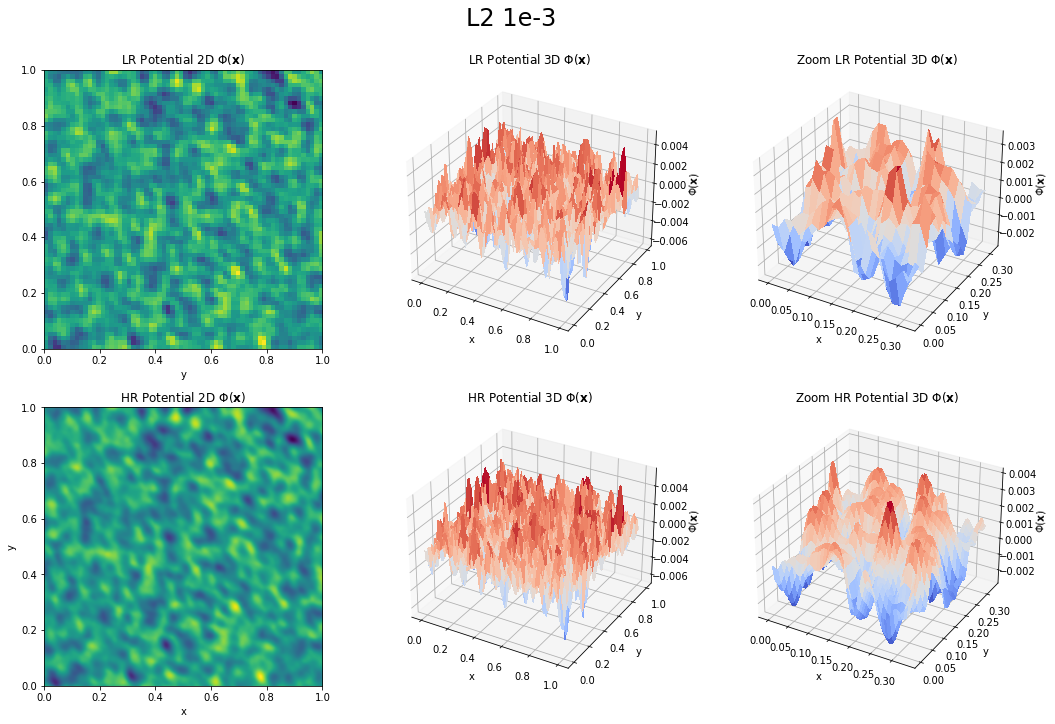

In [21]:
viz.plot_potential_wrapper_res_dict(results_dict['DivFreeNet_L2-1e-3'], title='L2 1e-3')
plt.show()

In [ ]:
viz.plot_model_losses(results_dict['DivFreeNet'], title=model.name)

In [ ]:
# model (RFF + MLP)
do_rff = True
fft_scale = 10
fft_nfeat = 256

nin = 2  # = x and y coordinates
nout = 1 # = in the mlp we predict the potential, ux and uy components followed
mlp_layers = [nin] + [256]*3 + [nout]
last_activation_fun = torch.nn.Tanh()

lam_pde = 1
lam_reg = 0

model = DivFreeRFFNet('DivFreeNet_L2-0', 
                      mlp_layers, last_activation_fun,
                      do_rff, fft_nfeat, fft_scale,
                      lam_reg=lam_reg, lam_pde=lam_pde)

# TRAIN!
model.to(device)
model.fit(trainloader, epochs=5000) # we are not afraid to overfit the data, this is coord-based MLP!
results_dict[model.name] = evl.results_potential_to_dict(Xlr, Xmr, Xhr, Ulr, Umr, Uhr, model, device)

In [ ]:
# model (RFF + MLP)
do_rff = True
fft_scale = 10
fft_nfeat = 256

nin = 2  # = x and y coordinates
nout = 1 # = in the mlp we predict the potential, ux and uy components followed
mlp_layers = [nin] + [256]*3 + [nout]
last_activation_fun = torch.nn.Tanh()

lam_pde = 1
lam_reg = 1e-2

model = DivFreeRFFNet('DivFreeNet_L2-1e-2', 
                      mlp_layers, last_activation_fun,
                      do_rff, fft_nfeat, fft_scale,
                      lam_reg=lam_reg, lam_pde=lam_pde)

# TRAIN!
model.to(device)
model.fit(trainloader, epochs=5000) # we are not afraid to overfit the data, this is coord-based MLP!
results_dict[model.name] = evl.results_potential_to_dict(Xlr, Xmr, Xhr, Ulr, Umr, Uhr, model, device)

In [ ]:
viz.plot_potential_wrapper_res_dict(results_dict['DivFreeNet_L2-1e-3'], title='L2 1e-3')
plt.show()
viz.plot_potential_wrapper_res_dict(results_dict['DivFreeNet_L2-0'], title='L2 0')
plt.show()

In [ ]:
u_dicts = [
    {'vel':Ulr, 'size':L, 'label': r'$U_{gt}$ $64 \times 64$', 'style': '--'},
    {'vel':Uhr, 'size':H, 'label': r'$U_{gt}$ $256 \times 256$', 'style': '--'},
    
    {'vel':results_dict['DivFreeNet_L2-1e-3']['LR']['u'], 
     'size':results_dict['DivFreeNet_L2-1e-3']['LR']['size'],
     'label': r'$U_{pred}$ $64 \times 64$', 'style': '-'},
    {'vel':results_dict['DivFreeNet_L2-1e-3']['HR']['u'], 
     'size':results_dict['DivFreeNet_L2-1e-3']['HR']['size'], 
     'label': r'$U_{pred}$ $256 \times 256$', 'style': '-'},
    
    {'vel':results_dict['DivFreeNet_L2-0']['LR']['u'], 
     'size':results_dict['DivFreeNet_L2-0']['LR']['size'],
     'label': r'$U_{pred}$ $64 \times 64$', 'style': '-'},
    {'vel':results_dict['DivFreeNet_L2-0']['HR']['u'], 
     'size':results_dict['DivFreeNet_L2-0']['HR']['size'], 
     'label': r'$U_{pred}$ $256 \times 256$', 'style': '-'},
]

viz.plot_energy_spectra(u_dicts, title='Energy Spectra')
plt.show()

### Plot results and compare the two metods graphically

In [ ]:
viz.plot_model_losses(results_dict['DivFreeNet'], title=model.name)
plt.show()
viz.plot_model_losses(results_dict['DivFreeNet_RFF'], title=model.name)
plt.show()

In [ ]:
viz.plot_lr_hr_inset(Ulr, Uhr, L, H, title='GroundTruth RFF')
plt.show()
viz.plot_lr_hr_inset_wrapper_res_dict(results_dict['DivFreeNet'], title='Predition without RFF')
plt.show()
viz.plot_lr_hr_inset_wrapper_res_dict(results_dict['DivFreeNet_RFF'], title='Predition with RFF')
plt.show()

In [ ]:
viz.plot_lr_hr_inset_error_wrapper_res_dict(results_dict['DivFreeNet'], title='Error [ABS] without RFF')
plt.show()
viz.plot_lr_hr_inset_error_wrapper_res_dict(results_dict['DivFreeNet_RFF'], title='Error [ABS] with RFF')
plt.show()

In [ ]:
viz.plot_velocity_field_wrapper_res_dict(results_dict['DivFreeNet'], title='Predicted Velocity Field', step_lr=1, scale_lr=15, step_hr=4, scale_hr=5)
plt.show()
viz.plot_velocity_field_wrapper_res_dict(results_dict['DivFreeNet_RFF'], title='Predicted Velocity Field', step_lr=1, scale_lr=15, step_hr=4, scale_hr=5)
plt.show()

In [ ]:
viz.plot_potential_wrapper_res_dict(results_dict['DivFreeNet'], title='Without RFF')
plt.show()
viz.plot_potential_wrapper_res_dict(results_dict['DivFreeNet_RFF'], title='With RFF')
plt.show()

In [ ]:
u_dicts = [
    {'vel':Ulr, 'size':L, 'label': r'$U_{gt}$ $64 \times 64$', 'style': '--'},
    {'vel':Uhr, 'size':H, 'label': r'$U_{gt}$ $256 \times 256$', 'style': '--'},
    
    { 'vel':results_dict['DivFreeNet']['LR']['u'], 
     'size':results_dict['DivFreeNet']['LR']['size'],
     'label': r'NoRFF $U_{pred}$ $64 \times 64$', 'style': '-'},
    { 'vel':results_dict['DivFreeNet']['HR']['u'], 
     'size':results_dict['DivFreeNet']['HR']['size'], 
     'label': r'NoRFF $U_{pred}$ $256 \times 256$', 'style': '-'},
    
    { 'vel':results_dict['DivFreeNet_RFF']['LR']['u'], 
     'size':results_dict['DivFreeNet_RFF']['LR']['size'],
     'label': r'RFF $U_{pred}$ $64 \times 64$', 'style': '-'},
    { 'vel':results_dict['DivFreeNet_RFF']['HR']['u'], 
     'size':results_dict['DivFreeNet_RFF']['HR']['size'], 
     'label': r'RFF $U_{pred}$ $256 \times 256$', 'style': '-'},
]

viz.plot_energy_spectra(u_dicts, title='Energy Spectra')
plt.show()

## Nonlinearity at the output

### For-loop on ELU, ReLU, LeakyReLU, Tanh and Sigmoid

In [ ]:
# model (RFF + MLP)
do_rff = True
fft_scale = 10
fft_nfeat = 256

nin = 2  # = x and y coordinates
nout = 1 # = in the mlp we predict the potential, ux and uy components followed
mlp_layers = [nin] + [256]*3 + [nout]
last_activation_funs = {'ELU' : torch.nn.ELU(), 
                        'ReLU' : torch.nn.ReLU(),
                        'LeakyReLU' : torch.nn.LeakyReLU(),
                        'Tanh' : torch.nn.Tanh(),
                        'Sigmoid' : torch.nn.Sigmoid()}
hardcoded_divfree = False

for key in last_activation_funs:
    
    print(key)
    
    do_rff = True
    fft_scale = 10
    fft_nfeat = 256

    nin = 2  # = x and y coordinates
    nout = 1 # = in the mlp we predict the potential, ux and uy components followed
    mlp_layers = [nin] + [256]*3 + [nout]

    model = DivFreeRFFNet('DivFreeNet_RFF_%s' % key, 
                          mlp_layers, last_activation_funs[key],
                          do_rff, fft_nfeat, fft_scale, verbose=False)

    # TRAIN!
    model.to(device)
    model.fit(trainloader, epochs=3000) # we are not afraid to overfit the data, this is coord-based MLP!
    results_dict[model.name] = evl.results_potential_to_dict(Xlr, Xmr, Xhr, Ulr, Umr, Uhr, model, device)

### Inspect results

In [ ]:
for key in last_activation_funs:
    key = 'DivFreeNet_RFF_%s' % key
    viz.plot_potential_wrapper_res_dict(results_dict[key], title=key)
    plt.show()

### Show errors

In [ ]:
for key in last_activation_funs:
    key = 'DivFreeNet_RFF_%s' % key
    viz.plot_lr_hr_inset_error_wrapper_res_dict(results_dict[key], title='Error [ABS] with %s' % key)
    plt.show()